In [150]:
import datetime as dt
from datetime import date
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import sqlalchemy
import pymysql
import time, datetime
from datetime import datetime, timedelta
from datetime import timedelta, date
import time
from numpy import sort
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import kurtosis
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt,het_white
from statsmodels.stats.diagnostic import linear_harvey_collier, linear_reset, spec_white
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from yellowbrick.regressor import CooksDistance
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from sklearn.linear_model import LinearRegression


In [95]:
from numpy import unicode_


base = pd.read_csv(r"D:\analise_corr()\analise_dummy_ou_outros (version 1).csv",sep=';', encoding='ISO-8859-1')
base


C:\Users\lucas.valdomiro\AppData\Local\Temp\ipykernel_17952\3003405180.py:4: DtypeWarning: Columns (90,91,96,98,99,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  base = pd.read_csv(r"D:\analise_corr()\analise_dummy_ou_outros (version 1).csv",sep=';', encoding='ISO-8859-1')


,customer_answer,created_at,tipo_pedido_nps,tipo_venda,pv_pai,Atraso_Transp_s,Flag Atraso Fornecedor_s,Flag Atraso Coleta_s,Flag Atraso Cliente_s,[FLAG]Cancelado_S,...,[[entrega]] Achei o prazo de entrega muito longo.],[[entrega]] Achei o valor do frete muito alto.],[[entrega]] Não foi possível agendar a entrega.],"[atendimento]] (aberta) Outro. Por favor, especifique:]",(aberta) Como foi sua experiência enquanto esperava o seu produto?,[compra]] (aberta) Foi fácil realizar sua compra?],"[entrega]] (aberta) Por favor, nos conte mais sobre a sua experiência.",[entrega]] (aberta) Você ficou satisfeito(a) com a entrega?,"[pagamento]] (aberta) Visando melhorar essa experiência, você pode contar quais d","[produto]] (aberta) Por favor, nos conte mais sobre a sua resposta"
0,10,18/10/2022 12:19,Mista,1,28162012,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,10/10/2022 13:40,1P,1,28096157,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,18/10/2022 13:11,1P,1,27804324,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,06/10/2022 12:35,1P,1,28032244,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,27/10/2022 15:11,1P,1,28214644,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,10,05/10/2022 11:30,1P,1,27563413,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24571,10,09/09/2022 12:22,1P,1,27066272,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24572,9,06/09/2022 12:53,1P,1,26502162,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24573,0,11/09/2022 14:06,1P,1,27500197,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
import re
from numpy import unicode_


base = pd.read_csv(r"D:\analise_corr()\analise_dummy_ou_outros (version 1).csv",sep=';', encoding='ISO-8859-1')
base

def somase(data_frame):

    colunas = ['Flag Atraso Transporte2','Flag Atraso Fornecedor3','Flag Atraso Coleta4','Flag Atraso Cliente5','[FLAG]Cancelado',
    '[FLAG]Recompra_ff','[FLAG]Erro prazo transporte validacao','[FLAG]Cross','[FLAG]Atraso_criacao_OC','[FLAG]Reprogramacao_OC',
    '[FLAG]Atraso Fornecedor','[FLAG] Entregue','[FLAG] Pratica_indevida','[FLAG] Sac_pos_entrega','[FLAG] Reversa','[FLAG] PJ',
    '[FLAG] Mais de uma entrega','[FLAG]Importacao WMS','[FLAG] Recompra','[FLAG] Entrega_Mista','[FLAG] Virada_Faturamento',
    'FLAG - Infos_encontradas','[FLAG] Atraso limite','[FLAG] Oc sem bip','[FLAG] Insucesso','[FLAG] End. N.Localizado/Ausente',
    '[FLAG] Tempo Habil','[FLAG] Atraso Redespacho','[FLAG] Diarias','[FLAG] Atraso Coletas','[FLAG] Leves','[FLAG] Atraso CD',
    '[FLAG] Recompra assistencia','[FLAG] Recompra Total','[FLAG] Origem Recompra','[FLAG] Atraso Cliente*','FLAG_Parceiro',
    'FLAG_terceiras_parceiras','[FLAG] - Detrator_mais_entrega','[FLAG] - Categorias_detrator','[FLAG] Private_Label','Guide_flag'
                ]
   
    df_retorno = data_frame
    for coluna in colunas:
        try:
            nova_coluna = df_retorno.groupby('pv_pai')[coluna].sum()
            df_retorno = df_retorno.merge(nova_coluna, left_on='pv_pai', right_on='pv_pai',how='left')
            df_retorno.rename(columns={coluna + '_y': coluna + '_soma'}, inplace=True,errors='raise')
            print('realizado colunas: ', coluna + '_soma')
        except Exception as e:
            print('deu ruim: ', e)
    return df_retorno

        

base = somase(base)



base = base.drop_duplicates(subset='pv_pai', keep='first')
####
base = base.drop(columns=['3. Sac_pos_entrega_s','97 Atraso WMS_s','96 Recompra_s','Reclamacao_cliente_s','Info_Encontradas_s','Coluna34','Coluna4',
'Coluna2','cidade_cliente','pedped','cep','chave_nfm','chave_ped','nf_fornecedor','fornecedor','nf_mi','data_compra_cliente','sku',
'categoria_old','categoria_new','head_categoria','descricao','chave_pedped','pedido_x','origem','destino','tp_t3','data_criacao_oc',
'data_aprovacao','data_limite_fornecedor','data_expedicao','data_limite_cliente','data_limite_coleta','data_limite_transporte','data_bip',
'data_entregue','pz_total_x','nota_nfd','tp_nf','tp_eagle','status_pedido_portal','Atraso Local V1','OC','Motivo_Recompra','prazo_interno_x',
'prazo_interno_y','channel','Virada_FF_VAO','Pesso Juridica','pedido_prazo_fornecedor','pedido_prazo_transportadora','cotacao_prazo_transporte',
'cotacao_prazo_fornecedor','Título Romaneio','Motorista','Roteiro','Prioridade','Codigo_EDI','EDI','Importacao_FF','Atraso Local V2',
'92.Virada_ff_Vao','91.Erro de Prazo Transporte','89.Reversa','1. Depara Transportadora','2. Pratica_indevida','3. Sac_pos_entrega',
'97 Atraso WMS','96 Recompra','Consolidador','Data_resposta','Media_dia_x_resposta','Motivo_sac Entrega','Reclamacao_cliente','chave_TP',
'DePara_TP_Parceiro:','Rank_Regras','[Prazo] aux','Dia Sem. Aprovação','Feriado','Prazo Vendido','Delta prazo cotado',
'Data Limite Cotado','aux Comparação Prazo Total (Cotado x Vendido)','Aux_coleta','Prazo_interno','Prazo_x_exp','CEP2','Pedido_original_Recompra',
'Data_Limite_para_Recompra','nova_data_limite','Aging_cliente','data-entrega','Chave_espaco_2','Fornecedor_ocr_desc',
'Guide','Categoria_nova_estrutura','Cabe_casa',
'Yes_casa','% detrator_categorias','qtd. categoria_detrator','1 cat','2 cat','3 cat','4 cat','5 cat','Loja',
'[compra] Foi fácil realizar sua compra?','Estado_destino_sigla','Semana','Mês',
'[pagamento] Como foi a sua experiência com relação ao pagamento do produto adquirido?','Como foi sua experiência enquanto esperava o seu produto?','[entrega] Você ficou satisfeito(a) com a entrega?',
'[produto] O produto atendeu às suas expectativas?','[atendimento] Você ficou satisfeito com nosso atendimento?','[entrega]] A embalagem chegou com problemas (rasgada, danificada, molhada...)',
'[entrega]] A entrega foi feita fora do prazo','[[entrega]] Achei o prazo de entrega muito longo.]',
'[[entrega]] Achei o valor do frete muito alto.]','[[entrega]] Não foi possível agendar a entrega.]',
'[atendimento]] (aberta) Outro. Por favor, especifique:]','(aberta) Como foi sua experiência enquanto esperava o seu produto?',
'[compra]] (aberta) Foi fácil realizar sua compra?]','[entrega]] (aberta) Por favor, nos conte mais sobre a sua experiência.',
'[entrega]] (aberta) Você ficou satisfeito(a) com a entrega?','[pagamento]] (aberta) Visando melhorar essa experiência, você pode contar quais d',
'[produto]] (aberta) Por favor, nos conte mais sobre a sua resposta'
])

base
base.to_csv(r'base_dummy.csv', index=False)



base


C:\Users\lucas.valdomiro\AppData\Local\Temp\ipykernel_17952\3040704803.py:5: DtypeWarning: Columns (90,91,96,98,99,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  base = pd.read_csv(r"D:\analise_corr()\analise_dummy_ou_outros (version 1).csv",sep=';', encoding='ISO-8859-1')


realizado colunas:  Flag Atraso Transporte2_soma
realizado colunas:  Flag Atraso Fornecedor3_soma
realizado colunas:  Flag Atraso Coleta4_soma
realizado colunas:  Flag Atraso Cliente5_soma
realizado colunas:  [FLAG]Cancelado_soma
realizado colunas:  [FLAG]Recompra_ff_soma
realizado colunas:  [FLAG]Erro prazo transporte validacao_soma
realizado colunas:  [FLAG]Cross_soma
realizado colunas:  [FLAG]Atraso_criacao_OC_soma
realizado colunas:  [FLAG]Reprogramacao_OC_soma
realizado colunas:  [FLAG]Atraso Fornecedor_soma
realizado colunas:  [FLAG] Entregue_soma
realizado colunas:  [FLAG] Pratica_indevida_soma
realizado colunas:  [FLAG] Sac_pos_entrega_soma
realizado colunas:  [FLAG] Reversa_soma
realizado colunas:  [FLAG] PJ_soma
realizado colunas:  [FLAG] Mais de uma entrega_soma
realizado colunas:  [FLAG]Importacao WMS_soma
realizado colunas:  [FLAG] Recompra_soma
realizado colunas:  [FLAG] Entrega_Mista_soma
realizado colunas:  [FLAG] Virada_Faturamento_soma
realizado colunas:  FLAG - Infos

,customer_answer,created_at,tipo_pedido_nps,tipo_venda,pv_pai,Atraso_Transp_s,Flag Atraso Fornecedor_s,Flag Atraso Coleta_s,Flag Atraso Cliente_s,[FLAG]Cancelado_S,...,[FLAG] Recompra assistencia_soma,[FLAG] Recompra Total_soma,[FLAG] Origem Recompra_soma,[FLAG] Atraso Cliente*_soma,FLAG_Parceiro_soma,FLAG_terceiras_parceiras_soma,[FLAG] - Detrator_mais_entrega_soma,[FLAG] - Categorias_detrator_soma,[FLAG] Private_Label_soma,Guide_flag_soma
0,10,18/10/2022 12:19,Mista,1,28162012,0,0,0,0,0,...,0.0,0.0,0,0,2,BULKYBULKY,0,0,0,--
1,10,10/10/2022 13:40,1P,1,28096157,0,0,0,0,0,...,0.0,0.0,0,0,1,BULKY,0,0,0,-
2,10,18/10/2022 13:11,1P,1,27804324,0,0,0,0,0,...,0.0,0.0,0,0,1,TERCEIRA,0,1,0,-
3,10,06/10/2022 12:35,1P,1,28032244,0,0,0,0,0,...,0.0,0.0,0,0,1,BULKY,0,1,1,-
4,10,27/10/2022 15:11,1P,1,28214644,0,0,0,0,0,...,0.0,0.0,0,0,1,PARCEIRO,0,1,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24566,0,16/09/2022 12:36,1P,1,27491686,0,0,0,0,0,...,0.0,0.0,0,0,1,TERCEIRA,0,1,1,In Store
24567,10,18/10/2022 12:10,Mista,1,28272985,0,0,0,0,0,...,0.0,0.0,0,0,1,BULKY,0,0,0,-
24571,10,09/09/2022 12:22,1P,1,27066272,0,0,0,0,0,...,0.0,0.0,0,0,1,BULKY,0,0,0,-
24572,9,06/09/2022 12:53,1P,1,26502162,1,0,0,1,0,...,0.0,0.0,0,1,1,TERCEIRA,0,1,0,-


In [142]:
base = base.drop(columns=['Atraso_Transp_s','Flag Atraso Fornecedor_s','Flag Atraso Coleta_s','Flag Atraso Cliente_s',
'[FLAG]Cancelado_S','[FLAG]Recompra_ff_S','[FLAG]Erro prazo transporte validacao_S','96.Atraso_importação_WMS_S',
'[FLAG]Cross_S','[FLAG]Atraso_criacao_OC_S','[FLAG]Reprogramacao_OC_S','92.Virada_ff_Vao_S','91.Erro de Prazo Transporte_S',
'[FLAG]Atraso Fornecedor_S','89.Reversa_S','NPS_NOTA_S','[FLAG] Entregue_S','[FLAG] Pratica_indevida_s','[FLAG] Sac_pos_entrega_s',
'[FLAG] Reversa_s','[FLAG] PJ_s','[FLAG] Mais de uma entrega_s','[FLAG]Importacao WMS_s','[FLAG] Recompra_s',
'[FLAG] Entrega_Mista_s','[FLAG] Virada_Faturamento_s','FLAG - Infos_encontradas_s','[FLAG] Atraso limite_s',
'[FLAG] Oc sem bip_s','[FLAG] Insucesso_s','[FLAG] End. N.Localizado/Ausente_s','[FLAG] Tempo Habil_s',
'[FLAG] Atraso Redespacho_s','[FLAG] Diarias_s','Flag Atraso Transporte2_x','Flag Atraso Fornecedor3_x',
'Flag Atraso Coleta4_x','Flag Atraso Cliente5_x','[FLAG]Cancelado_x','[FLAG]Recompra_ff_x','[FLAG]Erro prazo transporte validacao_x',
'96.Atraso_importação_WMS','[FLAG]Cross_x','[FLAG]Atraso_criacao_OC_x','[FLAG]Reprogramacao_OC_x','[FLAG]Atraso Fornecedor_x','NPS_NOTA',
'[FLAG] Entregue_x','[FLAG] Pratica_indevida_x','[FLAG] Sac_pos_entrega_x','[FLAG] Reversa_x','[FLAG] PJ_x','[FLAG] Mais de uma entrega_x',
'[FLAG]Importacao WMS_x','[FLAG] Recompra_x','[FLAG] Entrega_Mista_x','[FLAG] Virada_Faturamento_x','Info_Encontradas',
'FLAG - Infos_encontradas_x','[FLAG] Atraso limite_x','[FLAG] Oc sem bip_x','[FLAG] Insucesso_x',
'[FLAG] End. N.Localizado/Ausente_x','[FLAG] Tempo Habil_x','[FLAG] Atraso Redespacho_x',
'[FLAG] Diarias_x','[FLAG] Atraso Coletas_x','[FLAG] Leves_x','[FLAG] Atraso CD_x','[FLAG] Recompra assistencia_x',
'[FLAG] Recompra Total_x','[FLAG] Origem Recompra_x','[FLAG] Atraso Cliente*_x','FLAG_Parceiro_x','FLAG_terceiras_parceiras_x',
'[FLAG] - Detrator_mais_entrega_x','[FLAG] - Categorias_detrator_x','[FLAG] Private_Label_x','Guide_flag_x',
'[FLAG] Origem Recompra_soma',
'FLAG_terceiras_parceiras_soma',
'Guide_flag_soma'
])

base.head()


,customer_answer,created_at,tipo_pedido_nps,tipo_venda,pv_pai,Flag Atraso Transporte2_soma,Flag Atraso Fornecedor3_soma,Flag Atraso Coleta4_soma,Flag Atraso Cliente5_soma,[FLAG]Cancelado_soma,...,[FLAG] Atraso Coletas_soma,[FLAG] Leves_soma,[FLAG] Atraso CD_soma,[FLAG] Recompra assistencia_soma,[FLAG] Recompra Total_soma,[FLAG] Atraso Cliente*_soma,FLAG_Parceiro_soma,[FLAG] - Detrator_mais_entrega_soma,[FLAG] - Categorias_detrator_soma,[FLAG] Private_Label_soma
0,10,18/10/2022 12:19,Mista,1,28162012,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0,2,0,0,0
1,10,10/10/2022 13:40,1P,1,28096157,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0,1,0,0,0
2,10,18/10/2022 13:11,1P,1,27804324,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0,1,0,1,0
3,10,06/10/2022 12:35,1P,1,28032244,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0,1,0,1,1
4,10,27/10/2022 15:11,1P,1,28214644,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0,1,0,1,0


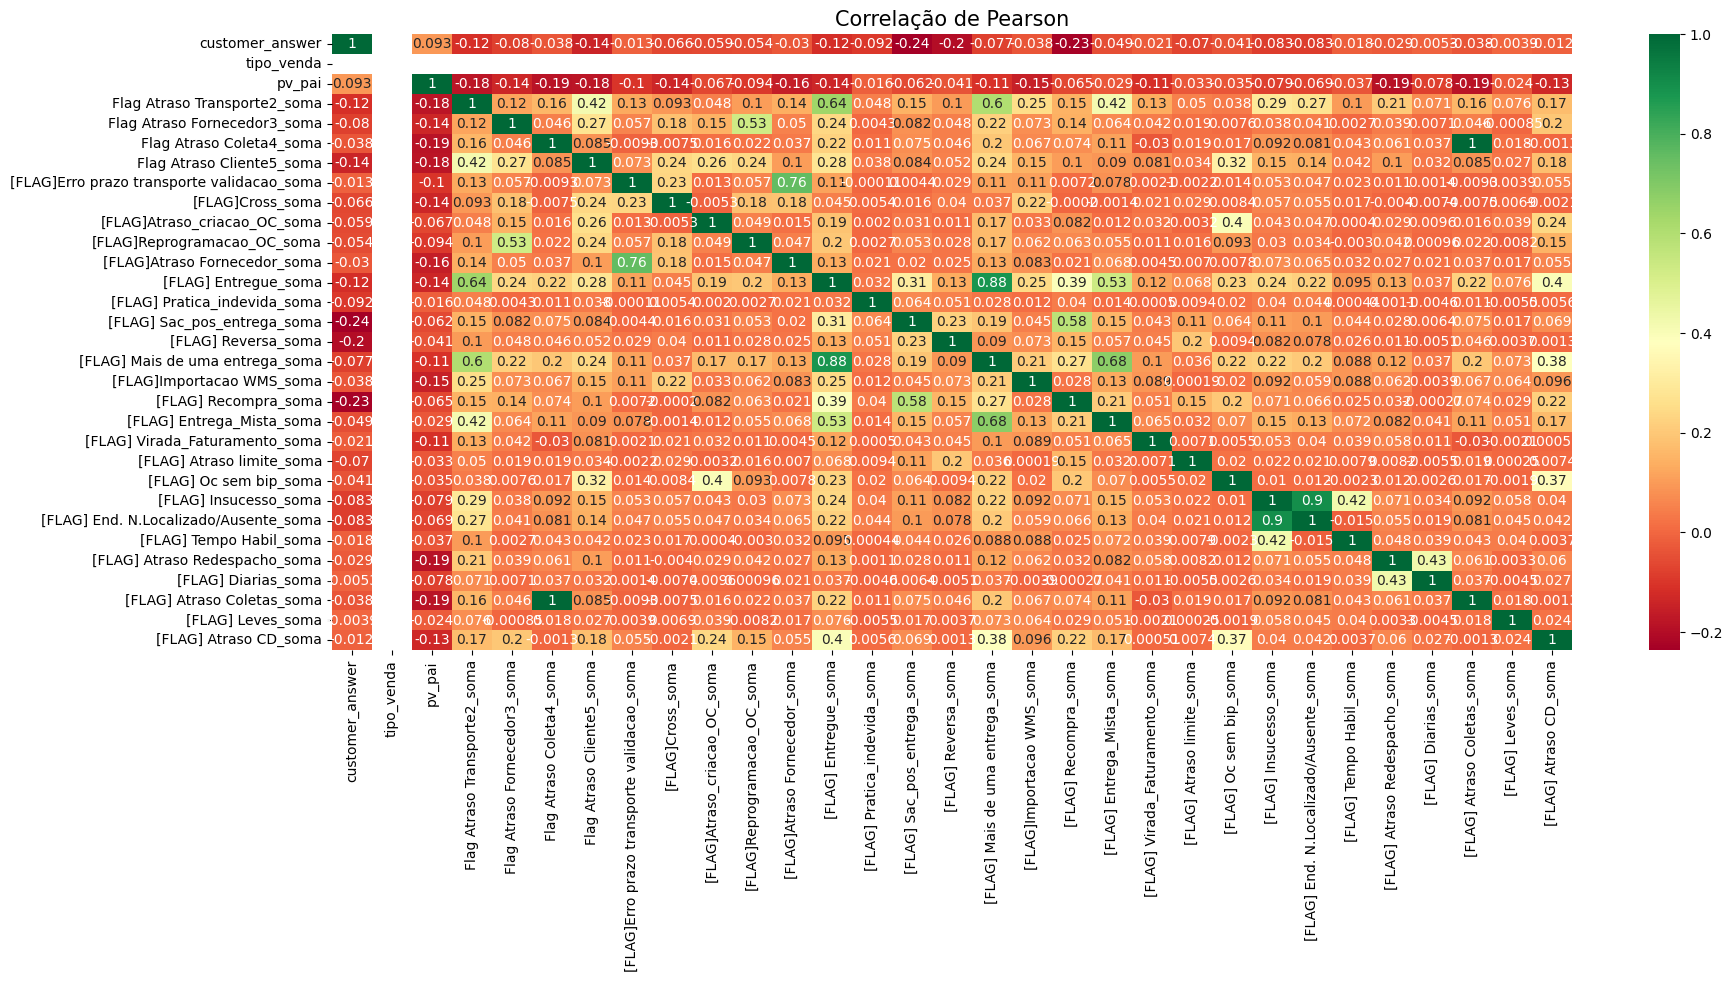

In [145]:

selecionado = base.drop(columns=['[FLAG]Cancelado_soma','[FLAG]Recompra_ff_soma','[FLAG] PJ_soma','FLAG - Infos_encontradas_soma','[FLAG] Recompra assistencia_soma','[FLAG] Recompra Total_soma','[FLAG] Atraso Cliente*_soma','FLAG_Parceiro_soma','[FLAG] - Detrator_mais_entrega_soma','[FLAG] - Categorias_detrator_soma','[FLAG] Private_Label_soma'])
printselecionado.shape
plt.figure(figsize=(20,8))
sns.heatmap(selecionado.corr(), annot = True, cmap= "RdYlGn");
plt.title('Correlação de Pearson',size=15);

In [ ]:
#Variáveis independentes
X = cerveja.drop(['Consumo de cerveja (litros)','Data'],axis=1)
#Variável dependentes
y = cerveja['Consumo de cerveja (litros)']